<a href="https://colab.research.google.com/github/michalis0/DataMining_and_MachineLearning/blob/master/week7/Text_Analytics_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining and Machine Learning - Week 7
# Text Analytics 2

[Text Analytics](https://people.ischool.berkeley.edu/~hearst/text-mining.html) (or text mining) is the process of deriving high-quality information from text. It involves "the discovery by computer of new, previously unknown information, by automatically extracting information from different written resources." Written resources may include websites, books, emails, reviews, and articles.

### This will be one of the most difficult lab sessions of the semester. Don't hesitate to ask if anything is unclear!

### Table of Contents
#### 0. Project: Git and GitHub
#### 1. Recap on text representation
* 1.1 Some important concepts
* 1.2 Bag of Words (BOW)
* 1.3 TF-IDF

#### 2. Introduction to Gensim and Word Embedding
* 2.1 Word embedding with Word2Vec
* 2.2 Exercise

#### 3. Complaints Classification: TF-IDF vs. Doc2Vec
* 3.1 Load and clean data
* 3.2 EDA
* 3.3 Classification using TF-IDF and Logistic Regression
* 3.4 Classification using Doc2Vec and Logistic Regression

Author: Luc Kunz

## 0. Project: Git and GitHub
For the project, you will have to work with Git and GitHub. The following documentation can be useful to you:
* [Git and GitHub tutorial for beginners](https://www.youtube.com/playlist?list=PL4cUxeGkcC9goXbgTDQ0n_4TBzOO0ocPR)
* [GitHub Desktop video 1](https://www.youtube.com/watch?v=fJtyf62yAb8)
* [GitHub Desktop video 2](https://www.youtube.com/watch?v=GqNAD4XoZ6k)
* [Git Cheat Sheet](https://education.github.com/git-cheat-sheet-education.pdf)

If you're having troubles completing your project using Git and/or GitHub Desktop, please let me know by email/slack and we can arrange an additional lab session on how to do a python project with Git and GitHub Desktop.

In [1]:
# Import required packages
import gensim
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import bs4 as bs
import urllib.request
import spacy
import string
import math
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns

# Load English language model of spacy
sp = spacy.load('en_core_web_sm')

# Warnings
import warnings
warnings.filterwarnings("ignore")

## 1. Recap on text representation
In order to be able to use texts as inputs for classification, we have to transform them into numbers (i.e. vectors). There are several ways of doing this.

### 1.1 Some important concepts
* Document = some text i.e. a string (e.g. a sentence, a tweet, paragraph of text, book, news article, etc.).
* Corpus = collection of documents.
* Dictionary = list of unique tokens in (preprocessed) corpus.
* Vector = mathematical representatation of a document (e.g. Bag of Words).
* Model = algorithm used for transforming vectors from one representation to another (e.g. TF-IDF).

In [2]:
# A document
doc = 'Tom confessed that he had fallen in love with me' # single quotes
doc = "Tom confessed that he had fallen in love with me" # double quotes
doc = """Tom confessed that he had fallen in love with me.""" # triple quotes

In [3]:
# A corpus
d1 = "Tom confessed that he had fallen in love with me"
d2 = "We musn't joke around with love"
d3 = "Human-caused climate change has caused land ice to melt and ocean water to expand"
d4 = "Climate change is not really happening"
d5 = "We asked Tom what he wanted for Christmas"
corpus = [d1, d2, d3, d4, d5]

# Preprocessing
from gensim.utils import simple_preprocess
processed_corpus = []
for doc in corpus:
  processed_corpus.append(simple_preprocess(doc))
processed_corpus

[['tom',
  'confessed',
  'that',
  'he',
  'had',
  'fallen',
  'in',
  'love',
  'with',
  'me'],
 ['we', 'musn', 'joke', 'around', 'with', 'love'],
 ['human',
  'caused',
  'climate',
  'change',
  'has',
  'caused',
  'land',
  'ice',
  'to',
  'melt',
  'and',
  'ocean',
  'water',
  'to',
  'expand'],
 ['climate', 'change', 'is', 'not', 'really', 'happening'],
 ['we', 'asked', 'tom', 'what', 'he', 'wanted', 'for', 'christmas']]

In [4]:
# A dictionary
from gensim import corpora
dictionary = corpora.Dictionary(processed_corpus)
print(dictionary)

Dictionary<36 unique tokens: ['confessed', 'fallen', 'had', 'he', 'in']...>


In [5]:
dictionary.token2id

{'confessed': 0,
 'fallen': 1,
 'had': 2,
 'he': 3,
 'in': 4,
 'love': 5,
 'me': 6,
 'that': 7,
 'tom': 8,
 'with': 9,
 'around': 10,
 'joke': 11,
 'musn': 12,
 'we': 13,
 'and': 14,
 'caused': 15,
 'change': 16,
 'climate': 17,
 'expand': 18,
 'has': 19,
 'human': 20,
 'ice': 21,
 'land': 22,
 'melt': 23,
 'ocean': 24,
 'to': 25,
 'water': 26,
 'happening': 27,
 'is': 28,
 'not': 29,
 'really': 30,
 'asked': 31,
 'christmas': 32,
 'for': 33,
 'wanted': 34,
 'what': 35}

### 1.2 Bag of Words (BOW)

Bag of Words is the simplest approach to achieve the transformation of documents into vectors. It is divided into two basic steps:
* Create a dictionary of unique words from the corpus.
* Analyse the documents, i.e. for each word in the dictionary and each document, add 1 if the word is in the document, otherwise 0.

Let's try to code it from scratch using spacy:

In [6]:
# Tokens in document
def get_tokens(document):
  doc_tokens = []
  for token in sp(document):
      if (token.is_punct == False) and (token.is_space == False):
        doc_tokens.append(token.lower_)
  return doc_tokens

In [7]:
# List of unique words in corpus (dictionary)
def vocabulary(corpus):
  # Delare output
  word_list = []
  # Loop documents - lower each word and add it to the output
  for document in corpus:
    spacy_doc = sp(document)
    for token in spacy_doc:
      if token.lower_ not in word_list and (token.is_punct == False) and (token.is_space == False):
        word_list.append(token.lower_)
  # Return output
  return word_list
    
vocabulary(corpus)

['tom',
 'confessed',
 'that',
 'he',
 'had',
 'fallen',
 'in',
 'love',
 'with',
 'me',
 'we',
 "musn't",
 'joke',
 'around',
 'human',
 'caused',
 'climate',
 'change',
 'has',
 'land',
 'ice',
 'to',
 'melt',
 'and',
 'ocean',
 'water',
 'expand',
 'is',
 'not',
 'really',
 'happening',
 'asked',
 'what',
 'wanted',
 'for',
 'christmas']

We now have a function to get the words of a document and a function to get the unique words of a corpus of documents. We can use them to create the Bag of Words.

In [8]:
# Bag of Words
def bow(document, corpus):
  # Get tokens
  doc_tokens = get_tokens(document)
  corpus_tokens = vocabulary(corpus)
  # Initialization
  bag = {}
  for token in corpus_tokens:
    bag[token] = 0
  # Add 1 if token is in document
  for token in doc_tokens:
    bag[token] += 1
  # Return
  return bag

bow(d1, corpus)

{'tom': 1,
 'confessed': 1,
 'that': 1,
 'he': 1,
 'had': 1,
 'fallen': 1,
 'in': 1,
 'love': 1,
 'with': 1,
 'me': 1,
 'we': 0,
 "musn't": 0,
 'joke': 0,
 'around': 0,
 'human': 0,
 'caused': 0,
 'climate': 0,
 'change': 0,
 'has': 0,
 'land': 0,
 'ice': 0,
 'to': 0,
 'melt': 0,
 'and': 0,
 'ocean': 0,
 'water': 0,
 'expand': 0,
 'is': 0,
 'not': 0,
 'really': 0,
 'happening': 0,
 'asked': 0,
 'what': 0,
 'wanted': 0,
 'for': 0,
 'christmas': 0}

In [9]:
# Dataframe - all documents in corpus
bag_of_words = []
for doc in corpus:
  bag = bow(doc, corpus)
  bag_of_words.append(bag)
  
pd.DataFrame(bag_of_words)

,tom,confessed,that,he,had,fallen,in,love,with,me,...,expand,is,not,really,happening,asked,what,wanted,for,christmas
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,1


Remarks:
* This is not perfect (e.g. we could remove stopwords, use n-grams, lemmas).
* We can use [CountVectorizer](https://https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) from sklearn as shown below.

In [10]:
# Using CountVectorizer
vectorizer = CountVectorizer()
bag_of_words = vectorizer.fit_transform(corpus).todense()
bag_of_words

matrix([[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
         1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
        [1, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
         0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0]], dtype=int64)

In [11]:
# Features
vectorizer.vocabulary_

{'tom': 30,
 'confessed': 7,
 'that': 28,
 'he': 14,
 'had': 11,
 'fallen': 9,
 'in': 17,
 'love': 21,
 'with': 35,
 'me': 22,
 'we': 33,
 'musn': 24,
 'joke': 19,
 'around': 1,
 'human': 15,
 'caused': 3,
 'climate': 6,
 'change': 4,
 'has': 13,
 'land': 20,
 'ice': 16,
 'to': 29,
 'melt': 23,
 'and': 0,
 'ocean': 26,
 'water': 32,
 'expand': 8,
 'is': 18,
 'not': 25,
 'really': 27,
 'happening': 12,
 'asked': 2,
 'what': 34,
 'wanted': 31,
 'for': 10,
 'christmas': 5}

In [12]:
# DataFrame
bag_of_words = pd.DataFrame(bag_of_words, columns=vectorizer.get_feature_names_out())
bag_of_words

,and,around,asked,caused,change,christmas,climate,confessed,expand,fallen,...,ocean,really,that,to,tom,wanted,water,we,what,with
0,0,0,0,0,0,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,1,0,0,2,1,0,1,0,1,0,...,1,0,0,2,0,0,1,0,0,0
3,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,1,0,1,1,0


Advantages of BOW:
* No need of huge corpus of words to get good results in practice.
* Easy to understand (i.e. not mathematically complex).

Disadvantages of BOW:
* A lot of zeros (imagine a corpus of 1000 articles) --> consume memory and space.
* Does not maintain any context information ("I eat a fish" vs. "A fish eats me").
* Half solutions: n-grams, specifiying min_df and max_df (see [documentation](https://https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)).


### 1.3 TF-IDF
TF-IDF is a type of bag of words approach where instead of adding zeros and ones in the embedding vector, you add floating numbers that contain more useful information compared to zeros and ones. The idea is to emphasize words that appear in few documents in the corpus. A word that appear many times but only in one document will have a high value (close to one) compared to words that appear many times in many documents. This word is then very useful to identify the document.

TF(word, document) = Term frequency = (Number of occurences of a word in document)/(Total words in the document)
- greater if word appears many times in document

IDF(word) = Inverse Document Frequency = Log((Total number of documents)/(Number of documents containing the word))
- greater if word appears in fewer doucuments

TF-IDF = TF*IDF

In [13]:
# Term frequency (TF)
def tf(document):
  # Get tokens
  tokens = get_tokens(document)
  # Initialization
  term_freq = {}
  for token in tokens:
    term_freq[token] = 0
  # Increment
  for token in tokens:
    term_freq[token] += 1/len(tokens)
  # Return
  return term_freq

tf(d3)

{'human': 0.06666666666666667,
 'caused': 0.13333333333333333,
 'climate': 0.06666666666666667,
 'change': 0.06666666666666667,
 'has': 0.06666666666666667,
 'land': 0.06666666666666667,
 'ice': 0.06666666666666667,
 'to': 0.13333333333333333,
 'melt': 0.06666666666666667,
 'and': 0.06666666666666667,
 'ocean': 0.06666666666666667,
 'water': 0.06666666666666667,
 'expand': 0.06666666666666667}

In [14]:
# Inverse document frequency
def idf(corpus):
  # Get list of unique words in corpus
  voc = vocabulary(corpus)
  # Initialization
  inv_doc_freq = {}
  for word in voc:
    inv_doc_freq[word] = 0
  # Number of apparition of word
  for word in voc:
    for document in corpus:
      doc_tokens = get_tokens(document)
      if word in doc_tokens:
        inv_doc_freq[word] += 1
  #print(inv_doc_freq)
  #print("\n----------------------\n")
  # IDF
  inv_doc_freq = {k: math.log(len(corpus) / inv_doc_freq[k]) for k in inv_doc_freq.keys()}
  # Return
  return inv_doc_freq

idf(corpus)

{'tom': 0.9162907318741551,
 'confessed': 1.6094379124341003,
 'that': 1.6094379124341003,
 'he': 0.9162907318741551,
 'had': 1.6094379124341003,
 'fallen': 1.6094379124341003,
 'in': 1.6094379124341003,
 'love': 0.9162907318741551,
 'with': 0.9162907318741551,
 'me': 1.6094379124341003,
 'we': 0.9162907318741551,
 "musn't": 1.6094379124341003,
 'joke': 1.6094379124341003,
 'around': 1.6094379124341003,
 'human': 1.6094379124341003,
 'caused': 1.6094379124341003,
 'climate': 0.9162907318741551,
 'change': 0.9162907318741551,
 'has': 1.6094379124341003,
 'land': 1.6094379124341003,
 'ice': 1.6094379124341003,
 'to': 1.6094379124341003,
 'melt': 1.6094379124341003,
 'and': 1.6094379124341003,
 'ocean': 1.6094379124341003,
 'water': 1.6094379124341003,
 'expand': 1.6094379124341003,
 'is': 1.6094379124341003,
 'not': 1.6094379124341003,
 'really': 1.6094379124341003,
 'happening': 1.6094379124341003,
 'asked': 1.6094379124341003,
 'what': 1.6094379124341003,
 'wanted': 1.6094379124341003,

In [15]:
# TF-IDF
def tfidf(document, corpus):
  # TF
  tf_bag = tf(document)
  # IDF
  idf_bag = idf(corpus)
  # TF*IDF
  tfidf_bag = {k: tf_bag[k]*idf_bag[k] for k in tf_bag.keys()}
  
  return tfidf_bag

tfidf(d3, corpus)

{'human': 0.10729586082894002,
 'caused': 0.21459172165788004,
 'climate': 0.06108604879161034,
 'change': 0.06108604879161034,
 'has': 0.10729586082894002,
 'land': 0.10729586082894002,
 'ice': 0.10729586082894002,
 'to': 0.21459172165788004,
 'melt': 0.10729586082894002,
 'and': 0.10729586082894002,
 'ocean': 0.10729586082894002,
 'water': 0.10729586082894002,
 'expand': 0.10729586082894002}

In [16]:
# DataFrame
bag_of_words_tfidf = []
for doc in corpus:
  bag = tfidf(doc, corpus)
  bag_of_words_tfidf.append(bag)
  
pd.DataFrame(bag_of_words_tfidf).fillna(0)

,tom,confessed,that,he,had,fallen,in,love,with,me,...,expand,is,not,really,happening,asked,what,wanted,for,christmas
0,0.091629,0.160944,0.160944,0.091629,0.160944,0.160944,0.160944,0.091629,0.091629,0.160944,...,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.152715,0.152715,0.000000,...,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.107296,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.26824,0.26824,0.26824,0.26824,0.00000,0.00000,0.00000,0.00000,0.00000
4,0.114536,0.000000,0.000000,0.114536,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.00000,0.00000,0.00000,0.20118,0.20118,0.20118,0.20118,0.20118


Remarks:
* This is not perfect (e.g. we could remove stopwords, use n-gramsm lemmas)
* We can use [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from sklearn as shown below.

In [17]:
# Using TfidfVectorizer
vectorizer = TfidfVectorizer()
bag_of_words = vectorizer.fit_transform(corpus).todense()

# DataFrame
bag_of_words = pd.DataFrame(bag_of_words, columns=vectorizer.get_feature_names_out())
bag_of_words

,and,around,asked,caused,change,christmas,climate,confessed,expand,fallen,...,ocean,really,that,to,tom,wanted,water,we,what,with
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.340925,0.000000,0.340925,...,0.000000,0.000000,0.340925,0.000000,0.275056,0.000000,0.000000,0.000000,0.000000,0.275056
1,0.000000,0.449342,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.362526,0.000000,0.362526
2,0.233751,0.000000,0.000000,0.467501,0.188589,0.000000,0.188589,0.000000,0.233751,0.000000,...,0.233751,0.000000,0.000000,0.467501,0.000000,0.000000,0.233751,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.350388,0.000000,0.350388,0.000000,0.000000,0.000000,...,0.000000,0.434297,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.379247,0.000000,0.000000,0.379247,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.305974,0.379247,0.000000,0.305974,0.379247,0.000000


Advantage of TF-IDF:
* Smart way of representing documents in corpus. More information is provided.

Disadvantages of TF-IDF (same as for BOW):
* A lot of zeros (imagine a corpus of 1000 articles) --> consume memory and space
* Does not maintain any context information ("I eat a fish" vs. "A fish eats me")
* Half solutions: n-grams, specifiying min_df and max_df (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)).

## 2. Introduction to Gensim and Word Embedding

In the following, we illustrate how we can find out the relations between words in a dataset, compute the similarity between them, or use the vector representation of those words as input for other applications such as text classification or clustering.

We use Gensim. A complete tutorial can be found [here](https://www.tutorialspoint.com/gensim/gensim_introduction.htm).

### 2.1 Word Embedding with Word2Vec

Word embediing approaches use deep learning and neural network-based techniques to convert words into corresponding vectors so that semantically similar vectors are close to each other in an N-dimensional space, where N refers to the dimensions of the vectors. The underlying assumption is that two words sharing similar contexts also share a similar meaning and consequently a similar vector representation from the model.

Two word embedding methods:
* Word2Vec by Google
* GloVe (Global vectors for Word Representation) by Stanford

Word2Vec gives astonishing results. Its ability to maintain a semantic relationship is reflected in a classic example where if you have a vector for the word "King" and you remove the vector represented by the word "Man" from the "King" and add "Woman", you get a vector that is close to the vector "Queen". 

* King - Man + Woman = Queen

Second example: "dog", "puppy" and "pup" are often used in similar situations, with similar surrounding words like "good", "fluffy" or "cute", and according to Word2Vec they will therefore share a similar vector representation.

In real applications, Word2Vec models are created from billions of documents. For example, [Google's Word2Vec model](https://code.google.com/archive/p/word2vec/) is formed from 3 million words and phrases.

GloVe is an extension of Word2Vec. More information [here](https://nlp.stanford.edu/projects/glove/). 

More detail on word embedding will be given in the class following this lab session. You can also click [here](https://www.youtube.com/watch?v=yFFp9RYpOb0) to watch a video on Word2Vec.

In [18]:
# Get texts from Wikipedia
def get_text(url):
  scrapped_data = urllib.request.urlopen(url)
  article = scrapped_data.read()
  parsed_article = bs.BeautifulSoup(article,'lxml')
  paragraphs = parsed_article.find_all('p')
  article_text = ""
  for p in paragraphs:
    article_text += p.text
  return article_text

machine_learning = get_text("https://en.wikipedia.org/wiki/Machine_learning")
ai = get_text("https://en.wikipedia.org/wiki/Artificial_intelligence")

#machine_learning

In [19]:
#ai

In [20]:
# Group texts in list
texts = [machine_learning, ai]

In [21]:
# Create tokenizer function for preprocessing
def spacy_tokenizer(text):

    # Define stopwords, punctuation, and numbers
    stop_words = spacy.lang.en.stop_words.STOP_WORDS
    punctuations = string.punctuation
    numbers = "0123456789"

    # Create spacy object
    mytokens = sp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # Remove sufix like ".[1" in "experience.[1"
    mytokens_2 = []
    for word in mytokens:
      for char in word:
        if (char in punctuations) or (char in numbers):
          word = word.replace(char, "")
      if word != "":
        mytokens_2.append(word)

    # Return preprocessed list of tokens
    return mytokens_2

# Tokenize texts
processed_texts = []
for text in texts:
  processed_text = spacy_tokenizer(text)
  processed_texts.append(processed_text)

In [22]:
for processed_text in processed_texts:
  print(processed_text[:20])

['machine', 'learning', 'ml', 'field', 'study', 'artificial', 'intelligence', 'concern', 'development', 'study', 'statistical', 'algorithm', 'learn', 'datum', 'generalize', 'unseen', 'datum', 'perform', 'task', 'explicit']
['artificial', 'intelligence', 'ai', 'refer', 'capability', 'computational', 'system', 'perform', 'task', 'typically', 'associate', 'human', 'intelligence', 'learning', 'reasoning', 'problem', 'solve', 'perception', 'decision', 'making']


In [23]:
# Word embedding 
### Parameters: 
#     - min_count: minimum number of occurence of single word in corpus to be taken into account
#     - size: dimension of the vectors representing the tokens
#     - IMPORTANT: processed_texts must be a list of lists of tokens object!
word2vec = Word2Vec(processed_texts, min_count=2, vector_size=100)
vocab = word2vec.wv.key_to_index
print(vocab)

{'ai': 0, 'learning': 1, 'use': 2, 'machine': 3, 'datum': 4, 'model': 5, 'learn': 6, 'algorithm': 7, 'intelligence': 8, 'artificial': 9, 'problem': 10, 'system': 11, 'human': 12, 'include': 13, 'network': 14, 'decision': 15, 'example': 16, 'training': 17, 'research': 18, 'field': 19, 'set': 20, 'neural': 21, 'method': 22, 'program': 23, 'train': 24, 'input': 25, 'base': 26, 'knowledge': 27, 'power': 28, 'application': 29, 'feature': 30, 'computer': 31, 'agent': 32, 'search': 33, 'output': 34, 'find': 35, 'theory': 36, 'task': 37, 'develop': 38, 'large': 39, 'process': 40, 'language': 41, 'approach': 42, 'deep': 43, 'solve': 44, 'goal': 45, 'image': 46, 'technique': 47, 'know': 48, 'researcher': 49, 'represent': 50, 'logic': 51, 'new': 52, 'classification': 53, 'risk': 54, 'rule': 55, 'bias': 56, 'data': 57, 'high': 58, 'time': 59, 'people': 60, 'term': 61, 'function': 62, 'tool': 63, 'label': 64, 'reasoning': 65, 'action': 66, 'like': 67, 'specific': 68, 'increase': 69, 'tree': 70, 'an

In [24]:
# Vector
v1 = word2vec.wv['intelligence'] 
v1

array([-0.04345902,  0.06330339,  0.01263315,  0.00784585,  0.02607231,
       -0.07790423,  0.03212652,  0.1060515 , -0.04398772, -0.01217287,
       -0.02631181, -0.0602807 , -0.00012719,  0.02230304,  0.01427038,
       -0.03227727,  0.01791517, -0.05574057, -0.01216385, -0.11237962,
        0.01540521,  0.03190437,  0.0352481 , -0.01980832, -0.01692476,
        0.00433433, -0.05328176, -0.04448415, -0.04708139, -0.00120635,
        0.05030176, -0.00523742,  0.02649252, -0.03406338, -0.00899807,
        0.07079905, -0.00310693, -0.04576768, -0.01993596, -0.09276051,
       -0.01323867, -0.04361514, -0.02762451,  0.01762446,  0.04011427,
       -0.03634905, -0.03743771, -0.0045412 ,  0.01797542,  0.04266987,
        0.01300333, -0.0298935 , -0.02265617, -0.0125665 , -0.03779178,
        0.01881744,  0.02777444, -0.00619712, -0.04167143,  0.00772709,
        0.0048024 ,  0.00961288, -0.00902757, -0.01421688, -0.0878461 ,
        0.04858023,  0.01916677,  0.04263579, -0.06896128,  0.05

In [25]:
# Similar vectors/words
sim_words = word2vec.wv.most_similar('intelligence')
sim_words

[('ai', 0.9844624996185303),
 ('machine', 0.9837609529495239),
 ('use', 0.9828115105628967),
 ('learning', 0.9807819128036499),
 ('system', 0.9796419143676758),
 ('learn', 0.9788923263549805),
 ('datum', 0.9784563779830933),
 ('model', 0.9776272177696228),
 ('artificial', 0.9768116474151611),
 ('problem', 0.9740386009216309)]

In [26]:
# Similarity between two words
word2vec.wv.similarity('ai', 'apple')

0.49819508

In [27]:
word2vec.wv.similarity('ai', 'machine')

0.98622537

Remarks:
* Many things can be done with Gensim (e.g. [topic modelling](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/))
* There exists also `Doc2Vec`, which is used to create a vectorised representation of a group of words (i.e. a document) taken collectively as a single unit (illustrated in the next section).

### 2.2 Exercise
Analyze the wikipedia article on [Coronavirus](https://en.wikipedia.org/wiki/Coronavirus) as above. Follow the steps and send your answers and code @Luc Kunz on Slack (direct message) or via Zoom (private). This is a good way to improve your participation grade.

In [28]:
# 1. Get text from URL - use the get_text() function defined above
coronavirus = get_text('https://en.wikipedia.org/wiki/Coronavirus')

# 2. Processing - tokenization using the spacy_tokenizer() function
processed_corona = spacy_tokenizer(coronavirus)
processed_corona[:10]

['coronaviruse',
 'group',
 'related',
 'rna',
 'virus',
 'cause',
 'disease',
 'mammal',
 'bird',
 'human']

In [29]:
# 3. What is the number of occurence of the word "virus"?
count = 0
for word in processed_corona:
  if word == 'virus':
    count += 1
count

70

In [30]:
# 4. Create a Word2Vec representation of the article with a min_count of 1 and a vector size of 50
word2vec_corona = Word2Vec([processed_corona], min_count=1, vector_size=50)

# 5. What is the 10 most similar words of "virus"
word2vec_corona.wv.most_similar('virus')

[('helical', 0.49124056100845337),
 ('like', 0.43380114436149597),
 ('minor', 0.42258220911026),
 ('intestinal', 0.40370166301727295),
 ('discovered', 0.4004249572753906),
 ('chicago', 0.3967163860797882),
 ('specificity', 0.3863425552845001),
 ('sample', 0.37277716398239136),
 ('aforementioned', 0.36697232723236084),
 ('farming', 0.3630199730396271)]

## 3. Complaints Classification: TF-IDF vs. Doc2Vec
We classify consumer finance complaints into 12 pre-defined categories using:
* TF-IDF and logistic regression
* Doc2Vec and logistic regression

We use the same tokenizer function, train-test split, classification algorithm, etc. The only difference is the mathematical representation (i.e. the vectorization from the tokens) of the complaints:
* TF-IDF: important words (or n-grams) are words (n-grams) that frequently appear in few documents.
* Doc2Vec: similar documents must be close to each other in n-dimensional space. Focus on the context of the documents.

### 3.1 Load and clean data
We work with a sample of a large data set from Data.gov that can be found on [here](https://catalog.data.gov/dataset/consumer-complaint-database).



In [31]:
# Load data from GitHub
path = "https://raw.githubusercontent.com/LKunz/Projets/refs/heads/main/Data%20Science/data/complaints_sample.csv"
df = pd.read_csv(path, index_col=0)
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2012-12-24,Credit card,NaN,Rewards,NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",IL,60611,NaN,NaN,Web,2012-12-24,Closed with explanation,Yes,No,217083
1,2013-12-17,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,NaN,NaN,REGIONS FINANCIAL CORPORATION,FL,33415,NaN,NaN,Web,2013-12-17,Closed with explanation,Yes,Yes,636638
2,2018-04-23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,TX,77386,NaN,NaN,Fax,2018-04-23,Closed with explanation,Yes,NaN,2883487
3,2019-01-04,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,NaN,NaN,HSBC NORTH AMERICA HOLDINGS INC.,AZ,94521,NaN,NaN,Referral,2019-01-08,Closed with explanation,Yes,NaN,3118526
4,2014-07-22,Debt collection,Payday loan,Cont'd attempts collect debt not owed,Debt is not mine,NaN,NaN,"ENOVA INTERNATIONAL, INC.",GA,30038,NaN,NaN,Web,2014-07-22,Closed with explanation,Yes,No,948293


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9101 entries, 0 to 9100
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date received                 9101 non-null   object
 1   Product                       9101 non-null   object
 2   Sub-product                   7942 non-null   object
 3   Issue                         9101 non-null   object
 4   Sub-issue                     6251 non-null   object
 5   Consumer complaint narrative  3137 non-null   object
 6   Company public response       3863 non-null   object
 7   Company                       9101 non-null   object
 8   State                         8946 non-null   object
 9   ZIP code                      8199 non-null   object
 10  Tags                          1171 non-null   object
 11  Consumer consent provided?    5869 non-null   object
 12  Submitted via                 9101 non-null   object
 13  Date sent to compa

The data set includes 18 columns and 9101 rows describing consumer complaints about financial products. In this case, we want to predict the `Product` categorie based on the text of the complaint (i.e. `Consumer complaint narrative`).

In [33]:
# Select columns of interest
data = df[["Product", "Consumer complaint narrative"]]
data.head()

,Product,Consumer complaint narrative
0,Credit card,NaN
1,Mortgage,NaN
2,"Credit reporting, credit repair services, or o...",NaN
3,Checking or savings account,NaN
4,Debt collection,NaN


Around 2/3 of the complaints are null values. They are not useful for the prediction so we drop them.

In [34]:
# Drop NaN
print(data.isnull().sum())
data = data.dropna().reset_index(drop=True)
data.head()

Product                            0
Consumer complaint narrative    5964
dtype: int64


,Product,Consumer complaint narrative
0,Credit card or prepaid card,Back in XX/XX/2019 a company called XXXX charg...
1,"Credit reporting, credit repair services, or o...",XXXX is reporting a single late payment over 7...
2,"Credit reporting, credit repair services, or o...","I have disputed the following account, ( 1 ) X..."
3,"Credit reporting, credit repair services, or o...",In XX/XX/XXXXI disputed the following items on...
4,Credit card or prepaid card,The response from Citi Cards has cleared up a ...


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3137 entries, 0 to 3136
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product                       3137 non-null   object
 1   Consumer complaint narrative  3137 non-null   object
dtypes: object(2)
memory usage: 49.1+ KB


We end up with 3137 complaints for which we would like to predict the product concerned.

### 3.2 EDA

In [36]:
# Total number of words - over 600,000
data['Consumer complaint narrative'].apply(lambda x: len(x.split(' '))).sum()

610062

In [37]:
# Sample
data['Consumer complaint narrative'].sample().values[0]

"I recieved a transfer of funds from someone for purchase of computer and the funds were fraudulent they froze my account and stated that freeze would be removed when investigation was complete so I was later told needed to close account and open another because funds had been released and now someone different was trying to withdraw funds so money was mine and could get it and deposit it in new acct. went ti bank where branch manager phoned fraud department who stated same thing that funds were mine and 8 could withdraw them and deposit some in new account, which I did and a few days later was told that funds were returned to person claiming that he dud not make deposit and now they claim I am responsible for those funds I don't belive I am responsible for any funds due to fact manager was told same thing that funds were mine to do with as I pleased and that someone not me was trying to withdraw funds and with proper ID could release funds to me and open new acct. with those funds or 

The data has been anonymized (i.e. names, dates, IDs, etc. have been replaced by XXXX).

In [38]:
# Imbalanced dataset
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    1123
Debt collection                                                                  640
Mortgage                                                                         378
Credit card or prepaid card                                                      211
Credit reporting                                                                 167
Student loan                                                                     129
Checking or savings account                                                      119
Credit card                                                                       74
Money transfer, virtual currency, or money service                                64
Bank account or service                                                           64
Vehicle loan or lease                                                             57
Payday loan, title loan, or personal loan                        

There are 17 categories. We group some of them together (e.g. `Credit card`, `Prepaid card`, and `Credit or prepaid card`) because they are sub-categories of each other. We end up with 12 categories.

In [39]:
# Clean
dic_replace = {'Credit reporting':'Credit reporting, credit repair services, or other personal consumer reports', 
               'Credit card':'Credit card or prepaid card', 
               'Payday loan':'Payday loan, title loan, or personal loan', 
               'Money transfers':'Money transfer, virtual currency, or money service',
               'Prepaid card':'Credit card or prepaid card',
               'Virtual currency':'Money transfer, virtual currency, or money service'}
data.replace(dic_replace, inplace=True)
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    1290
Debt collection                                                                  640
Mortgage                                                                         378
Credit card or prepaid card                                                      291
Student loan                                                                     129
Checking or savings account                                                      119
Money transfer, virtual currency, or money service                                72
Bank account or service                                                           64
Vehicle loan or lease                                                             57
Payday loan, title loan, or personal loan                                         55
Consumer Loan                                                                     38
Other financial service                                          

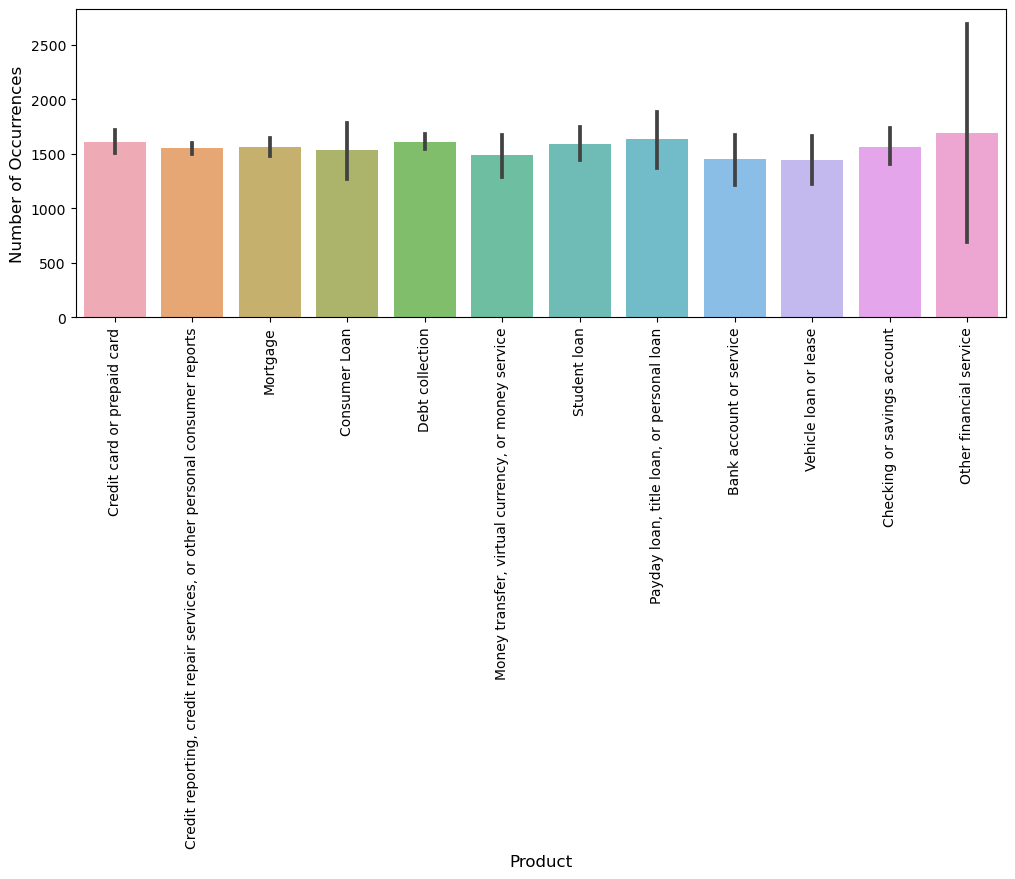

In [40]:
# Plot number of complaints per category
cnt_pro = data['Product'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=data['Product'], y=data.index, data=data, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [41]:
# Base rate
round(len(data[data.Product == "Credit reporting, credit repair services, or other personal consumer reports"]) / len (data), 4)

0.4112

### 3.3 Classification using TF-IDF and Logistic Regression

In [42]:
# Import packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

In [43]:
# Define tokenizer function
def spacy_tokenizer(sentence):

    punctuations = string.punctuation
    stop_words = spacy.lang.en.stop_words.STOP_WORDS

    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # Remove anonymous dates and people
    mytokens = [ word.replace('xx/', '').replace('xxxx/', '').replace('xx', '') for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in ["xxxx", "xx", ""] ]

    # Return preprocessed list of tokens
    return mytokens

In [44]:
# Select features
X = data['Consumer complaint narrative'] # the features we want to analyze
ylabels = data['Product'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=1234)

X_train

949     I have contacted Equifax several times via pho...
884     There are many mistakes appear in my report wi...
1441    I received a notice of debt from PSC regarding...
582     AFTER RECEIVING A CURRENT COPY OF MY CREDIT RE...
1515    A check was stolen from our checkbook and cash...
                              ...                        
664     Home Depot credit card number on bill does not...
3125    Lawsuit and judgment filed against me for a de...
1318    Was lied to about the payment and what the pay...
723     To All party involve XXXX XXXX. XXXX XXXX XXXX...
2863    I tried unsuccessfully today ( XX/XX/2017 ) to...
Name: Consumer complaint narrative, Length: 2509, dtype: object

In [45]:
y_train

949     Credit reporting, credit repair services, or o...
884     Credit reporting, credit repair services, or o...
1441                                      Debt collection
582     Credit reporting, credit repair services, or o...
1515                          Checking or savings account
                              ...                        
664                           Credit card or prepaid card
3125                                      Debt collection
1318                                      Debt collection
723     Credit reporting, credit repair services, or o...
2863    Credit reporting, credit repair services, or o...
Name: Product, Length: 2509, dtype: object

In [46]:
%%time
# Define vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), tokenizer=spacy_tokenizer)

# Define classifier
classifier = LogisticRegression(solver='lbfgs', max_iter=1000)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

CPU times: total: 2min 6s
Wall time: 2min 6s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(encoding='latin-1', min_df=5,
                                 ngram_range=(1, 2), sublinear_tf=True,
                                 tokenizer=<function spacy_tokenizer at 0x000001EF4A3910D0>)),
                ('classifier', LogisticRegression(max_iter=1000))])

0.7373


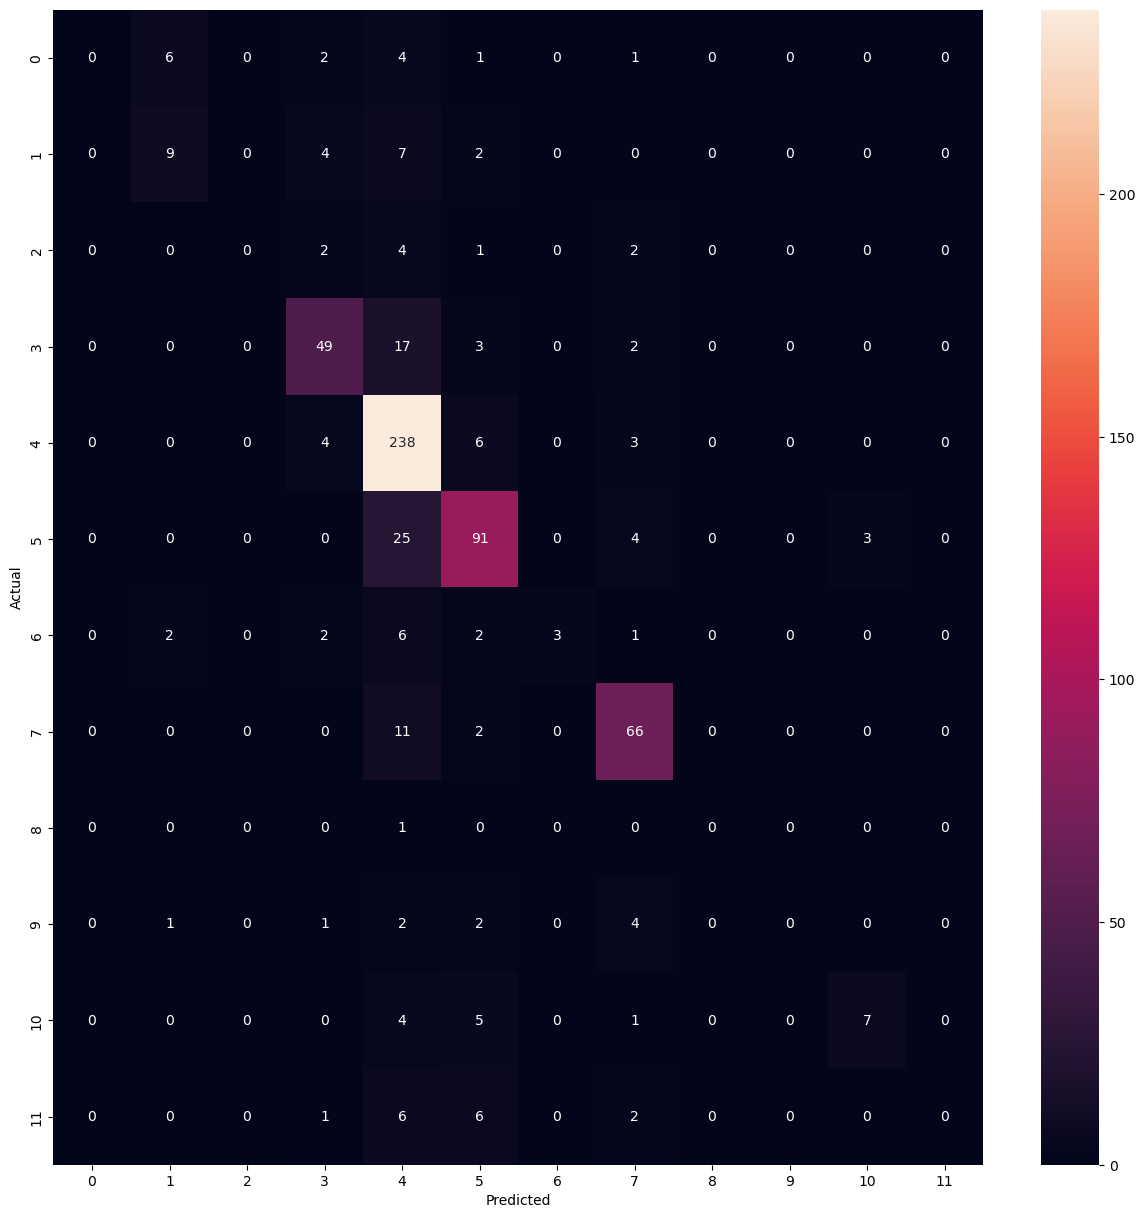

In [47]:
# Predictions
y_pred = pipe.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 3.4 Classification using Doc2Vec and Logistic Regression
We now try to do the same exercise, but using [Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html).

In [48]:
%%time
# Tokenize data - same tokenizer function as before
from gensim.models.doc2vec import TaggedDocument
sample_tagged = data.apply(lambda r: TaggedDocument(words=spacy_tokenizer(r['Consumer complaint narrative']), tags=[r.Product]), axis=1)
print(sample_tagged.head(20))

0     ([2019, company, charge, credit, card, 230.00,...
1     ([report, single, late, payment, 7, year, old,...
2     ([dispute, following, account, 1, 4.00, 2, 0.0...
3     ([i, dispute, follow, item, credit, report, bu...
4     ([response, citi, cards, clear, lot, confusion...
5     ([concern, contact, today, try, payment, mortg...
6     ([write, letter, file, complaint, begin, recei...
7     ([2016, purchase, truck, tell, finance, manage...
8     ([employer, submit, background, check, receive...
9     ([authorize, hard, credit, pull, credit, autho...
10    ([rushcard, access, fund, account, negative, b...
11    ([old, closed, account, remove, old, voluntary...
12    ([executive, offices, department, credit, card...
13    ([2, hard, inquiries, cbna, apply, card, suspe...
14    ([hard, inquiry, submit, credit, report, barcl...
15    ([request, credit, report, notice, account, re...
16    ([yes, send, letter, state, want, verification...
17    ([capital, auto, finance, tx, copy, letter

In [49]:
sample_tagged.values[10]

TaggedDocument(words=['rushcard', 'access', 'fund', 'account', 'negative', 'balance', 'week', 'customer', 'service', 'hang', 'numerous', 'time', 'hold', 'hr', 'time', 've', 'finally', 'tell', 'idea', 'money', 've', 'file', 'email', 'complaint', 'receive', 'different', 'ticket', 'number', "''", 'respond', 'week', 'basically', 'm', 'answer'], tags=['Credit card or prepaid card'])

In [50]:
# Train test split - same split as before
train_tagged, test_tagged = train_test_split(sample_tagged, test_size=0.2, random_state=1234)

train_tagged

949     ([contact, equifax, time, phone, online, class...
884     ([mistake, appear, report, understanding], [Cr...
1441    ([receive, notice, debt, psc, regard, medical,...
582     ([receive, current, copy, credit, report, disc...
1515    ([check, steal, checkbook, cash, 2000.00, unkn...
                              ...                        
664     ([home, depot, credit, card, number, bill, mat...
3125    ([lawsuit, judgment, file, defaulted, credit, ...
1318    ([lie, payment, payment, harass, -+, collectio...
723     ([party, involve, experian, dispute, departmen...
2863    ([try, unsuccessfully, today, 2017, equifax, c...
Length: 2509, dtype: object

In [51]:
test_tagged

2624    ([inform, amazon, 1, year, purchase, accrue, i...
2222    ([contact, company, having, receive, documenta...
2992    ([wrong, information, order, steal, identity, ...
1935    ([contact, ditech, financial, regard, incorrec...
1616    ([document, home, loan, false, state, 2, loan,...
                              ...                        
1694    ([buy, piece, furniture, sofa, recliner, '', b...
2666    ([hi, try, resolve, matter, company, phoenix, ...
2082    ([spouse, visit, local, branch, security, fina...
287     ([account, total, 9500.00, open, 2008, close, ...
516     ([send, copy, bill, experian, bill, experian, ...
Length: 628, dtype: object

In [52]:
# Allows to speed up a bit
import multiprocessing
cores = multiprocessing.cpu_count()

In [53]:
# Define Doc2Vec and build vocabulary
from gensim.models import Doc2Vec

model_dbow = Doc2Vec(dm=0, vector_size=30, negative=6, hs=0, min_count=1, sample=0, workers=cores)
model_dbow.build_vocab([x for x in train_tagged.values])

We now train the distributed bag of words model. In short, it trains a neural network and the optimal weights are the coefficients of the vectors of the documents. Therefore, similar documents will be close to each other in the N-dimentional space (N being the size of the vectors). More information on this [here](https://thinkinfi.com/simple-doc2vec-explained/).

In [54]:
# Train distributed Bag of Word model
model_dbow.train(train_tagged, total_examples=model_dbow.corpus_count, epochs=300)

In [55]:
# Select X and y
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=100)) for doc in sents])
    return targets, regressors

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [56]:
# Each document (i.e. complaint) is now a vector in the space of 30 dimentions.
# Similar complaints should have similar vector representation.
X_train[:3]

(array([ 0.17506956, -0.31823397, -0.69335735, -0.02513   , -0.32764897,
        -0.7644    , -0.6703356 , -0.9161136 , -0.4910298 , -0.5855878 ,
        -0.39054266, -0.46618366,  0.45496255, -0.43801907, -0.28003708,
        -0.27922508,  0.31863248,  1.1208963 ,  0.20633078, -1.0005575 ,
        -0.4913245 , -0.9546513 , -1.5447541 ,  0.01186735,  0.34488449,
         0.02123836, -0.49661547, -0.51141626, -0.51482445,  0.08559759],
       dtype=float32),
 array([ 0.17881514,  0.02323485, -1.1222087 ,  1.3597426 , -0.47079995,
        -0.01494664, -0.61730814, -1.0862181 ,  0.06830471,  0.5302344 ,
        -0.15921727,  0.47266006, -0.5644927 ,  0.07339415, -0.06827904,
        -0.54450315,  0.8223044 ,  0.4884405 ,  0.084347  , -0.76376265,
        -0.1683669 , -0.5209403 , -0.93486184,  0.03069505,  0.3929121 ,
         0.81113297, -0.5649017 , -0.39229447,  0.30646876, -0.28437394],
       dtype=float32),
 array([ 0.00269613,  0.4535472 , -1.2866927 , -0.48519507,  0.37377927,
   

0.6752


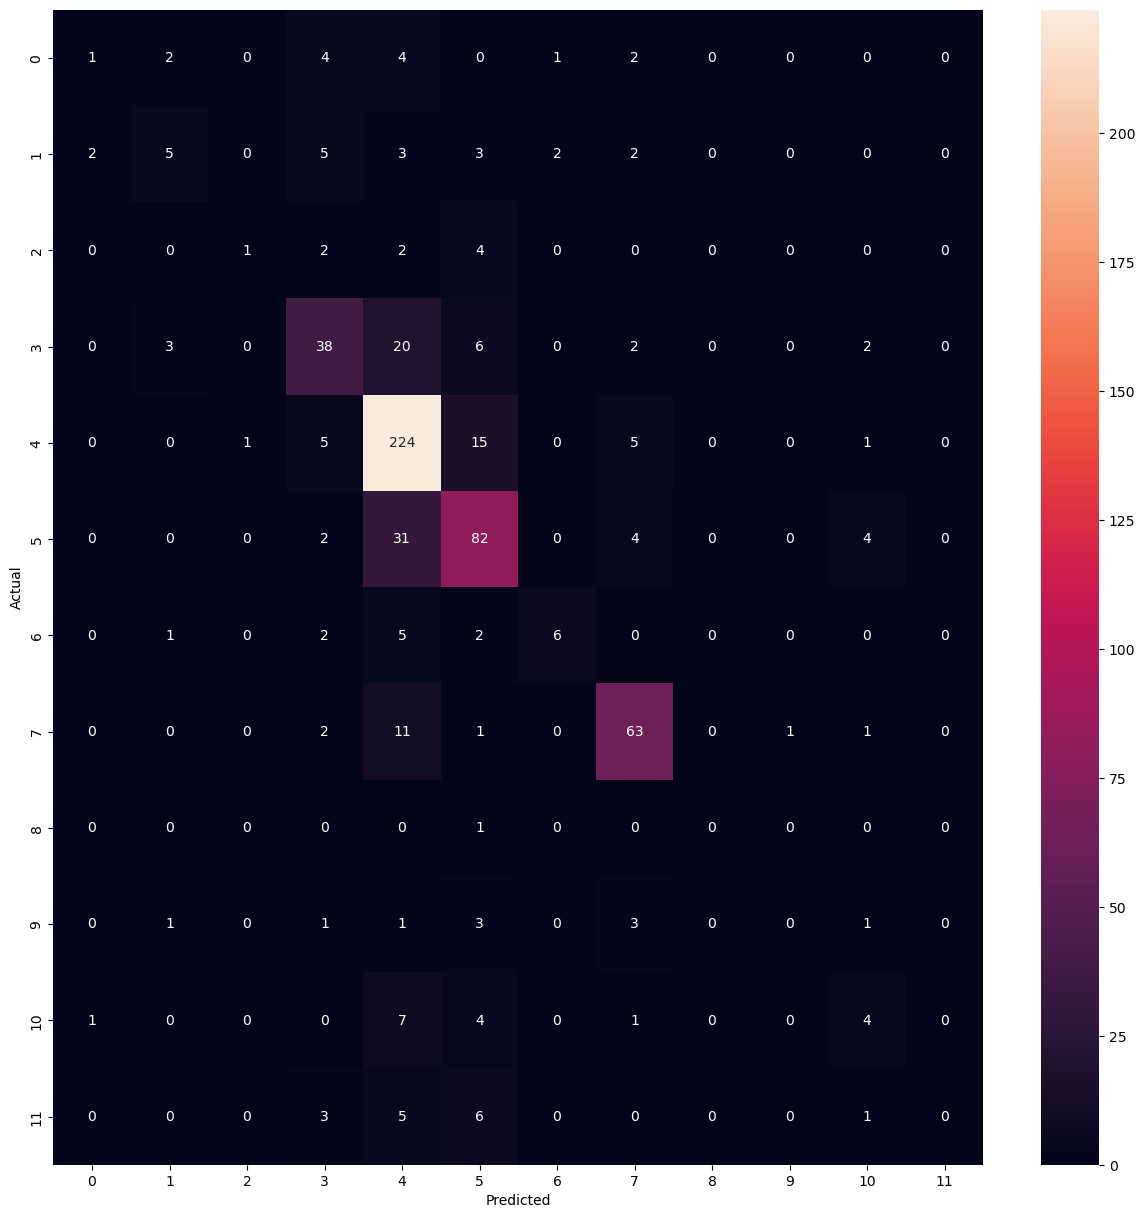

In [57]:
# Fit model on training set - same algorithm as before
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## References
* https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4
* https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f